## Importance Sampling
Assume we want to calculate the expectation $\mathbb{E}[f(X)]$

$$\mathbb{E}[f(X)] = \int_{-\infty}^\infty f(x)p(x)dx$$

where $p(x)$ is the probability density function associated to $X$.

We can approximate this expectation using numerical approximation (Monte Carlo simulation) by sampling $n$ random values from the distribution $p$ and then calculate the sample mean:

$$\bar{f}(x) = \frac{1}{n}\sum_i f(x_i)$$

The idea behind **importance sampling** is to use a simple re-formulation trick and write the expectation as

$$\mathbb{E}[f(X)] = \int_{-\infty}^\infty f(x)\frac{p(x)}{q(x)}q(x)dx$$

giving the expectation of $f(x)p(x)/q(x)$ over the distribution $q$.
And with that, allowing us to calculate the sample mean by sampling from $q$:

$$\bar{f}(x) = \frac{1}{n}\sum_i f(x_i)\frac{p(x)}{q(x)}$$

## Variance Reduction
The variance of the standard Monte Carlo estimator is given by:

$$\frac{1}{n}\text{Var}[f(x)] = \frac{1}{n}\mathbb{E}[(f(X)-\mathbb{E}[f(X)])^2]$$

The variance for the reformulated importance sampling estimator is:

$$\frac{1}{n}\text{Var}\left[\frac{p(x)}{q(x)}f(x)\right]$$

This give us a hint on how to find a way to reduce the variance. And indeed it is relatively easy to see that this variance could be reduced to 0 by choosing $q$ as:

$$q(x)=\frac{f(X)p(x)}{\mathbb{E}[f(X)]} \implies \frac{1}{n}\text{Var}[\mathbb{E}[f(X)]] = \frac{1}{n}\mathbb{E}[(\mathbb{E}[f(X)]-\mathbb{E}[\mathbb{E}[f(X)]])^2]=\frac{1}{n}\mathbb{E}[(\mathbb{E}[f(X)]-\mathbb{E}[f(X)])^2] = 0$$

Naturally, we don’t know $\mathbb{E}[f(X)]$, as the reason we are doing this sampling after all is to find the expectation of $f$.

However, we can think of the denominator of the previous expression as some normalisation constant, and consider to construct $q$ such that it has **high** density wherever $f(x)p(x)$ is **high**.

### Practical Example
For the sake of demonstration, we choose $f=\mathcal{N}(5, 1)$, and the probability distribution $p=\mathcal{N}(9,2)$ which do not overlap too well.


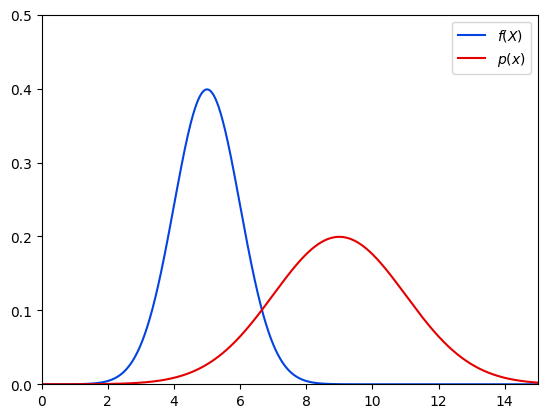

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm

f = norm(5, 1)
p = norm(9, 2)

x = np.arange(0, 15, 0.01)
plt.plot(x, f.pdf(x), label=r"$f(X)$", color='xkcd:blue')
plt.plot(x, p.pdf(x), label=r"$p(x)$", color='xkcd:red')
plt.xlim(0, 15)
plt.ylim(0, 0.50)
plt.legend()
plt.show()


To approximate numerically the expectation, as stated above, we would now sample values $x_i$ from the distribution $p$, and compute the mean of $f(x_i)$.

Intuitively one can see why sampling from this distribution is a bad idea: for most values sampled from $p$, $f$ will be close to 0, but for a few sampled values $f$ will be very large, thus we obtain a large variance.


In [2]:
N = 10000
samples = p.rvs(size=N)
f_sampling = f.pdf(samples)
mean = f_sampling.mean()
variance = f_sampling.var()
print (f"Numerical Simulation: mean {mean:.5f}, variance {variance:.5f}")

Numerical Simulation: mean 0.03578, variance 0.00767


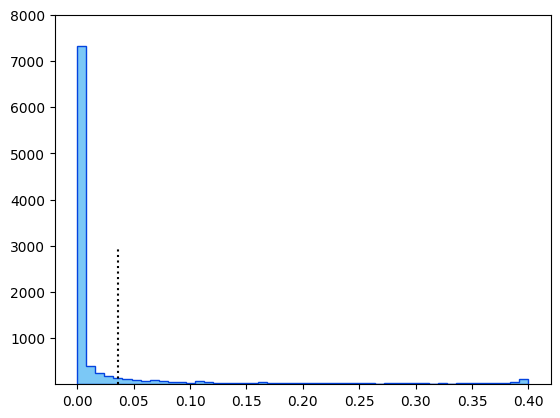

In [6]:
plt.hist(f_sampling, bins=50, range=(0, 0.4), histtype='stepfilled', color='xkcd:lightblue', edgecolor='xkcd:blue')
plt.vlines(mean, 0, 3000, color='black', linestyle=":")
#plt.yscale('log')
plt.ylim(1, 8000)
plt.show()


Therefore, as outlined above, we now try a new distribution $q = \mathcal{N}(5.8, 1)$, which satisfies the criterion that its pdf is high in regions where $f(x)p(x)$ is high.

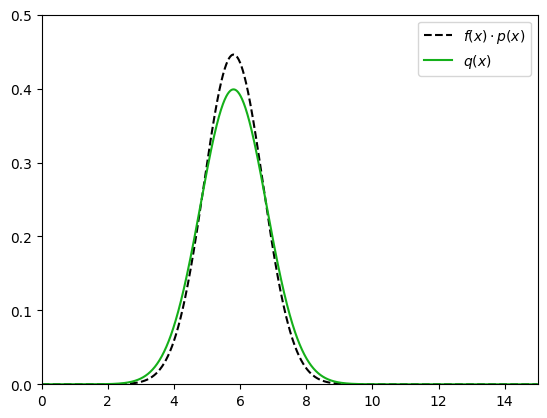

In [ ]:
q = norm(5.8, 1)
norm_cost = np.sum(q.pdf(x))/np.sum(f.pdf(x)*p.pdf(x))

plt.plot(x, norm_cost*f.pdf(x)*p.pdf(x), label=r"$f(x)\cdot p(x)$", color='black', linestyle="--")
plt.plot(x, q.pdf(x), label=r"$q(x)$", color='xkcd:green')
plt.xlim(0, 15)
plt.ylim(0, 0.5)
plt.legend()
plt.show()

In [ ]:
samples2 = q.rvs(size=N)
f_sampling2 = f.pdf(samples2)*p.pdf(samples2)/q.pdf(samples2)
mean2 = f_sampling2.mean()
variance2 = f_sampling2.var()
print (f"Numerical Simulation: mean {mean:.5f}, variance {variance:.5f}")
print (f"Importance Sampling: mean {mean2:.5f}, variance {variance2:.5f}")

Numerical Simulation: mean 0.03581, variance 0.00760
Importance Sampling: mean 0.03602, variance 0.00003


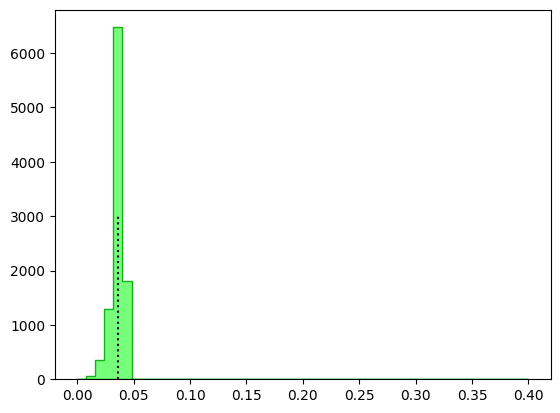

In [ ]:
plt.hist(f_sampling2, bins=50, range=(0, 0.4), histtype='stepfilled', color='xkcd:lightgreen', edgecolor='xkcd:green')
plt.vlines(mean2, 0, 3000, color='black', linestyle=":")
plt.show()

Thus, we still obtain the correct mean, but have reduced variance by a factor of 200 !

**Note** it’s not trivial to find $q$, and certainly there are much more difficult real-word scenarios.

For this example I actually plotted $p(x)f(x)$ and then picked a $q$ which resembled it best.

## How unlucky is a 25 standard deviation return ?

$$\theta := P(X\geq 25) = \mathbb{E}[\mathbb{1}_{X\geq 25}]  \quad\text{where } X\sim \mathcal{N}(0, 1)$$

The standard Monte Carlo approach proceeds as follows:
  1. Generate $X_1, X_2, \ldots ,X_n$ i.i.d. $\mathcal{N}(0,1)$;
  2. set $\mathbb{1}_j=\mathbb{1}_{X_j\geq 25}$ for $j=1,\ldots ,n$;
  3. set $\hat{\theta}=\sum_{j=1}^n \mathbb{1}_j/n$;
  4. compute approximate 95\% c.l. as $\hat{\theta}_n\pm 1.96\hat{\sigma}_n/\sqrt{n}$

Questions: why is this a bad idea ?


In [ ]:
import numpy as np

M = 1000000
Z = np.random.normal(size=M)

# Indicator function, count number of sampled variables above 25
ZT = np.where(Z>25, 1, 0)
X = np.mean(ZT)

# Calculate standard error and 95% Condifence intervals
sigma = np.std(ZT)
SE = sigma/np.sqrt(M)
CIs = [X-SE*1.96, X+SE*1.96]
print (X)
print(f'95% Confidence Levels for 25 St Dev. Returns are [{CIs[0]:0.3e}, {CIs[1]:0.3e}]')

0.0
95% Confidence Levels for 25 St Dev. Returns are [0.000e+00, 0.000e+00]


We have got 0 because not even one "simulation" returned a value larger than 25. So it would be better to say that the result is **undefined**.

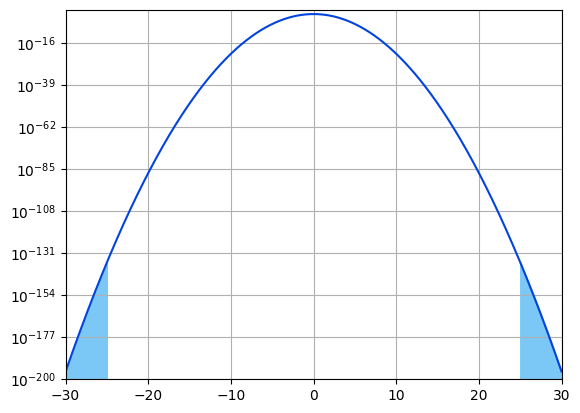

Starting today and simulating 1M experiments per second, most likely our Sun will be dead well before we have got a non-zero result from our MC.


Using the importance sampling technique instead we can improve our estimate giving a meanigful result.

Let's write
$$
\begin{equation}
\begin{aligned}
\theta &= \mathbb{E}[\mathbb{1}_{\{X\geq 25\}}] = \int_{-\infty}^{\infty}\mathbb{1}_{\{X\geq 25\}}\cfrac{1}{\sqrt{2\pi}}\exp{\left(-\frac{x^2}{2}\right)}dx = \\
&= \int_{-\infty}^{\infty}\mathbb{1}_{\{X\geq 25\}} \left(
  \cfrac{\frac{1}{\sqrt{2\pi}}\exp{\left(-\frac{x^2}{2}\right)}}{\frac{1}{\sqrt{2\pi}}\exp{\left(-\frac{(x-\color{red}{\mu})^2}{2}\right)}}
  \right) \frac{1}{\sqrt{2\pi}}\exp{\left(-\frac{(x-\color{red}{\mu})^2}{2}\right)}dx =\\
&= \mathbb{E}_\mu\left[\mathbb{1}_{\{X\geq 25\}} \cfrac{1}{\sqrt{2\pi}}\exp{\left(-\frac{-\color{red}\mu X+\color{red}\mu^2}{2}\right)} \right]
\end{aligned}
\end{equation}
$$

Now choosing $X\sim\mathcal{N}(\mu, 1)$ with $\mu=25$ leads to a much more efficient estimator as can be seen from the following simulation (**note how 1000 events are now enough to get a meaningful result**).

In [ ]:
from scipy.stats import norm

M = 1000
mu = 25

np.random.seed(1)

# Method 1 - use scipy stats PDF functions
p = norm(0, 1)
q = norm(mu, 1)
x = q.rvs(size=M)
ZT = np.where(x>25, 1, 0) * p.pdf(x)/q.pdf(x)

# Method 2 - direct with analytical ratio
#ZT = np.where(x>25,1,0)*np.exp(-mu*x + mu**2/2)

X = np.mean(ZT)
sigma = np.std(ZT)
SE = sigma/np.sqrt(M)
CIs = [X-SE*1.96,X+SE*1.96]
print (X)
print(f'95% Confidence Levels for 25 St Dev. Returns are [{CIs[0]:0.3e}, {CIs[1]:0.3e}]')

2.810646171611043e-138
95% Confidence Levels for 25 St Dev. Returns are [1.873e-138, 3.748e-138]


## Plain Vanilla Options and Importance Sampling

Suppose we wish to estimate the value of a call option which is well “out of the money” using Monte Carlo methods ($K \gg S_0$).

In this case, using crude Monte Carlo, the majority of the values randomly generated for $S_T$ would fall below the strike and contribute zero to the option price.

One possible remedy is to generate values of $S_T$ under a distribution that is more likely to exceed the strike, but of course this would increase the simulated value of the option. So we need to compensate for changing the underlying distibution by multiplying by a factor adjusting the mean (i.e. importance sampling).

More specifically, we wish to estimate

$$\mathbb{E}^{\mathbb{Q}}[e^{-rT}(S_0e^{Z_t}-K)^+],\text{ where }Z_t\sim\mathcal{N}((r-\sigma^2/2)T,\sigma^2T)$$

Suppose we modify the underlying probability measure of $Z_T$ to
$\mathbb{Q}_0$ with a larger drift.

The new simulation generates paths that are less likely to produce options expriring with zero value, and in a sense has this eliminated some computational waste.

In [3]:
import numpy as np

from scipy.stats import norm

def GBM(mu, sigma, X0, T, tsteps, N):
    X = np.zeros(shape=(tsteps, N))
    dt = T/tsteps
    X[0, :] = X0
    epsilon = np.random.normal(size=(tsteps-1, N))
    X[1:, :] = np.exp((mu-0.5*sigma**2)*dt+sigma*np.sqrt(dt)*epsilon)
    return np.cumprod(X, axis=0)

def d_plus(St, K, r, sigma, ttm):
    num = np.log(St/K) + (r + 0.5*sigma**2)*(ttm)
    den = sigma*np.sqrt(ttm)
    return num/den

def d_minus(St, K, r, sigma, ttm):
    return d_plus(St, K, r, sigma, ttm) - sigma*np.sqrt(ttm)

def call(St, K, r, sigma, ttm):
    if type(ttm) == list:
        ttm = np.array([t for t in ttm])
    else:
        ttm = ttm
    return (St*norm.cdf(d_plus(St, K, r, sigma, ttm)) -
            K*np.exp(-r*(ttm))*norm.cdf(d_minus(St, K, r, sigma, ttm)))


In [4]:
S0 = 100.0
K = 170.0
T = 1.0
mu = 0.06
vol = 0.20
N = 100
tsteps = 100

np.random.seed(1)
ST = GBM(mu, vol, S0, T, tsteps, N)
ST2 = GBM(0.5, vol, S0, T, tsteps, N)

C_BS = call(S0, K, mu, vol, 1)
print (f"{C_BS:.4f}")

0.0789


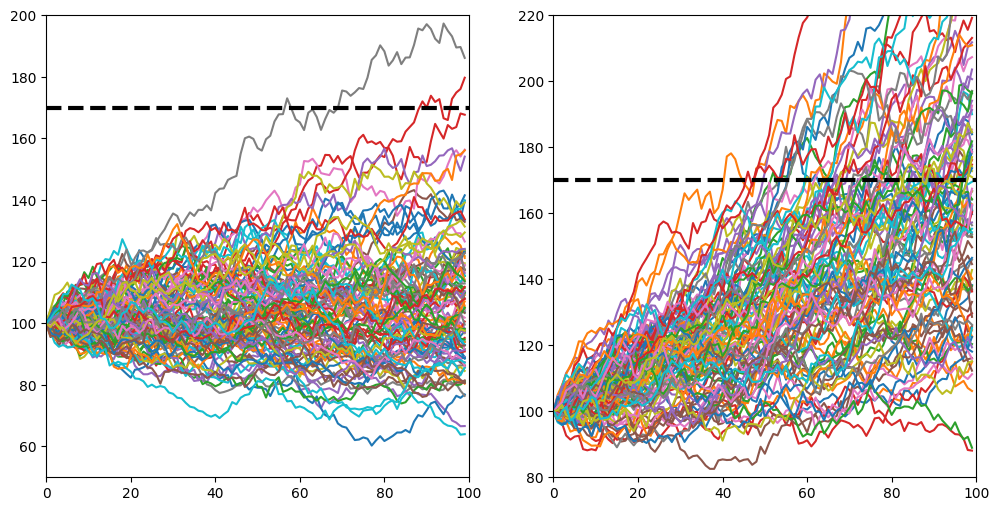

In [5]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.plot(ST)
ax1.hlines(K, 0, N, color='black', linestyle='--', linewidth=3)
ax1.set_xlim(0, N)
ax1.set_ylim(50, 200)
ax2.plot(ST2)
ax2.hlines(K, 0, N, color='black', linestyle='--', linewidth=3)
ax2.set_xlim(0, N)
ax2.set_ylim(80, 220)
plt.show()

There is a clear connection between importance sampling and Radon-Nikodym derivative:

$$\mathbb{E}[f(x)] = \int f(x)p(x) dx = \int f(x) \cfrac{p(x)}{q(x)} dx$$

$$\mathbb{E}^{\mathbb{Q}}[f(S_T)]= \mathbb{E}^{\mathbb{Q}_0}\left[f(S_T)\cfrac{d\mathbb{Q}}{d\mathbb{Q}_0}\right] $$

The importance sampling adjustment that insures that the estimator continues to be an unbiased estimator of the option price is the ratio of the two probability densities.

So we can simulate events under $\mathbb{Q}_0$ and the multiply by the Radon-Nikodym derivative.

So we get

$$\mathbb{E}^{\mathbb{Q}}[e^{-rT}(S_0 e^{Z_T} - K)^+], \text{ where } Z_T\sim \mathcal{N}((r-\cfrac{\sigma^2}{2})T, \sigma^2T)$$

$$\mathbb{E}^{\mathbb{Q}_0}[e^{-rT}(S_0 e^{Z_T} - K)^+], \text{ where } Z_T\sim \mathcal{N}(\mu T, \sigma^2T)$$


We would like to determine the "optimal" $\mu$ such that the variance is minimized. Unfortunately there is not straightforward way to do that. One can try to determine a realitvely optimal value by

$$\min_{\mu}\mathbb{E}^{\mathbb{Q}}\left[f^2(x)\cfrac{p(x)}{q_\mu(x)}\right]$$


In [6]:
from scipy.optimize import fmin, minimize

def Q0(mu, x, sigma, T):
  return norm(mu*T, sigma*T).pdf(x)

def Q(x, r, sigma, T):
  return norm((r - 0.5*sigma**2)*T, sigma*T).pdf(x)

def f(x, r, S0, K):
  return np.exp(-r*T)*np.maximum(0, S0*np.exp(x) - K)

M = 1000000
def arg_min(x, mu, sigma, T):
  x_T = np.random.normal(size=M)
  z = (mu - 0.5*sigma**2)*T + sigma*x_T*np.sqrt(T)
  return np.mean(f(z, mu, S0, K)**2*Q(z, mu, vol, T)/Q0(x, z, vol, T))

res = minimize(arg_min, 0.6, args=(mu, vol, T), method='Nelder-Mead', options={'maxiter':2000})
print (res)
mu_star = res.x

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.012807191452145612
             x: [ 6.295e-01]
           nit: 10
          nfev: 26
 final_simplex: (array([[ 6.295e-01],
                       [ 6.296e-01]]), array([ 1.281e-02,  1.287e-02]))


In [7]:
import pandas as pd

np.random.seed(1)
C0_is, SE_is = [], []
C0_wo, SE_wo = [], []

Ms = [100, 500, 1000, 2500, 5000, 10000, 25000, 50000]
for M in Ms:
  x_T = np.random.normal(size=M)
  z = mu_star*T - vol*x_T*np.sqrt(T)
  C_is = f(z, mu, S0, K)*Q(z, mu, vol, T)/Q0(mu_star, z, vol, T)

  z = (mu-0.5*vol**2)*T + vol*x_T*np.sqrt(T)
  C_wo = f(z, mu, S0, K)
  C0_is.append(np.mean(C_is))
  SE_is.append(np.std(C_is))
  C0_wo.append(np.mean(C_wo))
  SE_wo.append(np.std(C_wo))

data = pd.DataFrame({"M":Ms, "DP_wo":C0_wo, "DP_is":C0_is, "std_wo":SE_wo, "std_is":SE_is})
data['reduction'] = data['std_wo']/data['std_is']
print (data.head(20))

       M     DP_wo     DP_is    std_wo    std_is  reduction
0    100  0.000000  0.088340  0.000000  0.085636   0.000000
1    500  0.156567  0.074716  2.661602  0.082478  32.270467
2   1000  0.072207  0.080365  1.183912  0.085448  13.855288
3   2500  0.090879  0.078064  1.512354  0.083297  18.156072
4   5000  0.106882  0.079540  1.624668  0.084151  19.306581
5  10000  0.071713  0.078611  1.308213  0.083662  15.636928
6  25000  0.079021  0.078641  1.238422  0.083380  14.852823
7  50000  0.083900  0.078832  1.343988  0.083419  16.111264


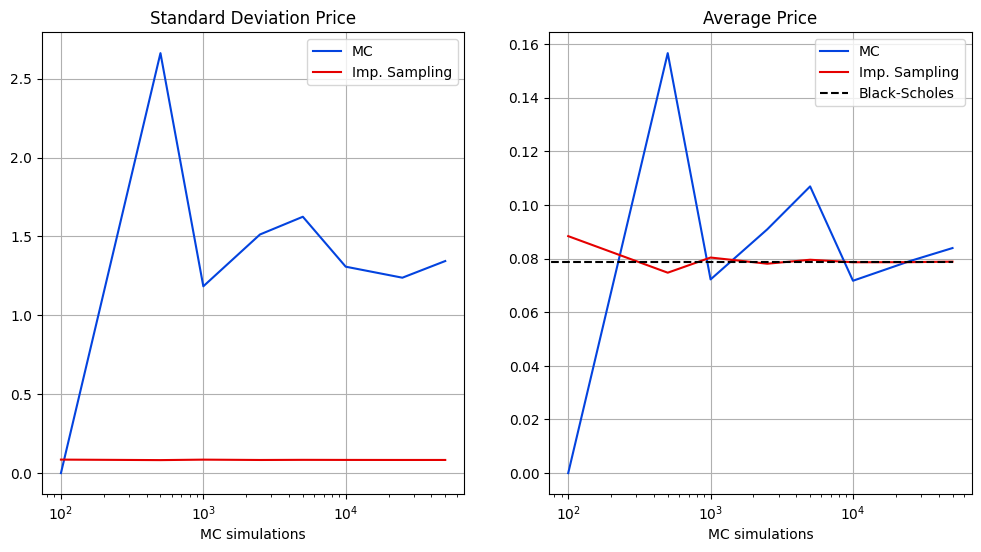

In [8]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
plt.subplot(1,2,1)
plt.plot(Ms, data['std_wo'], color='xkcd:blue', label='MC')
plt.plot(Ms, data['std_is'], color='xkcd:red', label='Imp. Sampling')
plt.legend()
plt.title("Standard Deviation Price")
plt.grid(True)
plt.xscale("log")
plt.xlabel("MC simulations")

plt.subplot(1,2,2)
plt.plot(Ms, data['DP_wo'], color='xkcd:blue', label='MC')
plt.plot(Ms, data['DP_is'], color='xkcd:red', label='Imp. Sampling')
plt.hlines(C_BS, 0, Ms[-1], color='black', linestyle="--", label="Black-Scholes")
plt.legend()
plt.xscale("log")
plt.title("Average Price")
plt.xlabel("MC simulations")
plt.grid(True)

plt.show()